Fork of Ryan Holbrook notebook, it is implemented:

* More EDA
* New Models
* Hybrid Model
* Tuning of the Hiperparameters, used library `Optuna`

In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.stats import norm

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


In [2]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")

    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


In [3]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
dfTrain = pd.read_csv(data_dir / "train.csv", index_col="Id")
dfTest = pd.read_csv(data_dir / "test.csv", index_col="Id")


dfTrain.Exterior2nd.unique()
print( dfTrain.shape, dfTest.shape )

(1460, 80) (1459, 79)


# EDA

First, we will analysis target(depend variable) `SalePrice`. 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

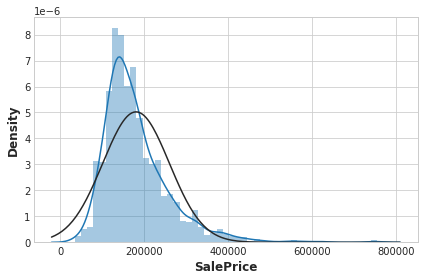

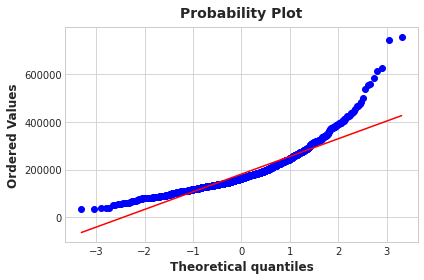

In [4]:
Y = dfTrain["SalePrice"]
sns.distplot(Y, fit =  norm)
fig = plt.figure()
res = stats.probplot(dfTrain['SalePrice'], plot=plt)

Y.describe()


### Skewness and Kurtosis

We see that the Target, show asymetric distribution with skew positive. While, the Kurtosis have highe value to indicate the presence of some outliears. 

In [5]:
print("Skewness: %f" % dfTrain['SalePrice'].skew())
print("Kurtosis: %f" % dfTrain['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Plot Categorical Variable "Overallqual" 

Box plot overallqual/saleprice

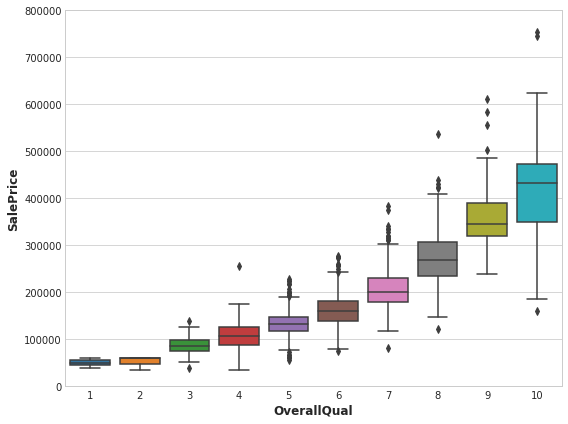

In [6]:
var = 'OverallQual'
data = pd.concat([dfTrain['SalePrice'], dfTrain[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

### Scatterplots

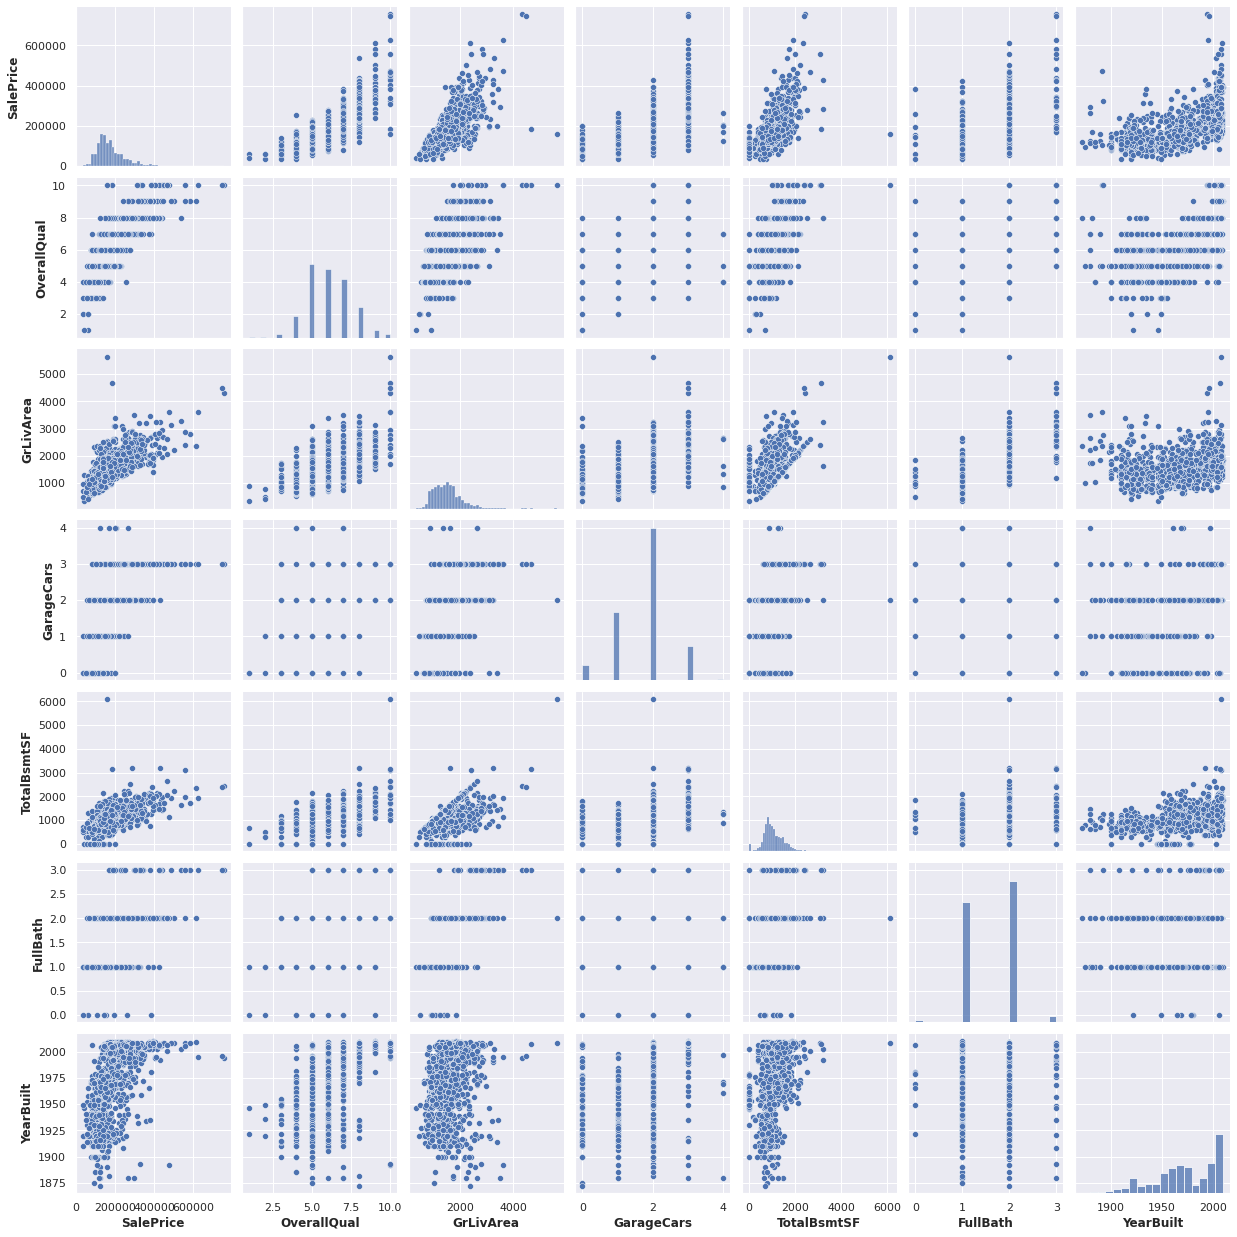

In [7]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(dfTrain[cols], size = 2.5)
plt.show();

### Missing Data

In [8]:
total = dfTrain.isnull().sum().sort_values(ascending=False)
percent = (dfTrain.isnull().sum()/dfTrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


### Clean Data ###

Some of the categorical features in this dataset have what are apparently typos in their categories:

Comparing these to `data_description.txt` shows us what needs cleaning. We'll take care of a couple of issues here, but you might want to evaluate this data further.

In [9]:
# read data_description for more cleaning

def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


### Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This hidden cell defines the `encode` function:

In [10]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to

# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [11]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def deleteVariables(DF, tol = 0.15):
    df= DF.copy()
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    df = df.drop((missing_data[missing_data['percent'] > tol]).index,1)
    df = df.drop(df.loc[df ['Electrical'].isnull()].index)
    return df

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [12]:
df_train, df_test = load_data()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

Uncomment and run this cell if you'd like to see what they contain. Notice that `df_test` is
missing values for `SalePrice`. (`NA`s were willed with 0's in the imputation step.)

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function we created in Lesson 1 that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.


In [13]:

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [14]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #

In Lesson 2 we saw how to use mutual information to compute a *utility score* for a feature, giving you an indication of how much potential the feature has. This hidden cell defines the two utility functions we used, `make_mi_scores` and `plot_mi_scores`: 

In [15]:
# mutual information

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0) # mutual information regression
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [16]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). As we talked about in Tutorial 2, the top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

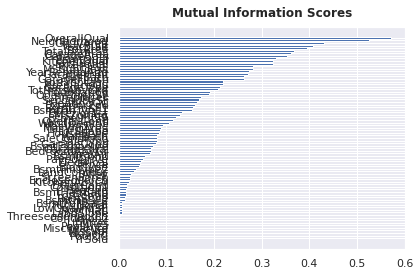

In [17]:
plot_mi_scores(mi_scores  )

In [18]:
X.loc[:, mi_scores > 0.0].describe().T 

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1460.0,57.623288,34.664304,0.0,42.00,63.0,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
FirstFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0


In [19]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

Removing them does lead to a modest performance gain:

In [20]:
X = df_train.copy()
y = X.pop("SalePrice")
Xd = drop_uninformative(X, mi_scores)

score_dataset(Xd, y)

0.14338026718687277

Later, we'll add the `drop_uninformative` function to our feature-creation pipeline.

# Step 3 - Create Features #

Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:

```
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X
```

Let's go ahead and define one transformation now, a [label encoding](https://www.kaggle.com/alexisbcook/categorical-variables) for the categorical features:

In [21]:
# all to numerical
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

X =  label_encode(X)

A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories. If you wanted to try a linear regression model (also popular in this competition), you would instead want to use a one-hot encoding, especially for the features with unordered categories.

## Create Features with Pandas ##

This cell reproduces the work you did in Exercise 3, where you applied strategies for creating features in Pandas. Modify or add to these functions to try out other feature combinations.

In [22]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X





Here are some ideas for other transforms you could explore:
- Interactions between the quality `Qual` and condition `Cond` features. `OverallQual`, for instance, was a high-scoring feature. You could try combining it with `OverallCond` by converting both to integer type and taking a product.
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Interactions between numeric and categorical features that describe the same thing. You could look at interactions between `BsmtQual` and `TotalBsmtSF`, for instance.
- Other group statistics in `Neighboorhood`. We did the median of `GrLivArea`. Looking at `mean`, `std`, or `count` could be interesting. You could also try combining the group statistics with other features. Maybe the *difference* of `GrLivArea` and the median is important?

In [23]:
# New ideas

def diffGrLivArea(df):
    X = pd.DataFrame()
    X["DiffGrLivArea"] = df.GrLivArea - df.GrLivArea.mean(axis=0)
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    X["StdNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("std")
    X["CountNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("count")
    return X


def logTransformer(df):
    X = pd.DataFrame()
    X['logGrLivArea'] = np.log(df['GrLivArea'])
    X['logTotalBsmtSF'] = df['TotalBsmtSF']
    X['HasBsmt'] = pd.Series(len(X['logTotalBsmtSF']), index=df.index)
    X['HasBsmt'] = 0 
    X.loc[X['logTotalBsmtSF']>0,'HasBsmt'] = 1
    
    X.loc[X['HasBsmt']==1,'logTotalBsmtSF'] = np.log(X['logTotalBsmtSF'])
    
    return X

## k-Means Clustering ##

The first unsupervised algorithm we used to create features was k-means clustering. We saw that you could either use the cluster labels as a feature (a column with `0, 1, 2, ...`) or you could use the *distance* of the observations to each cluster. We saw how these features can sometimes be effective at untangling complicated spatial relationships.

In [24]:

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
 "Neighborhood",
]


def cluster_labels(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


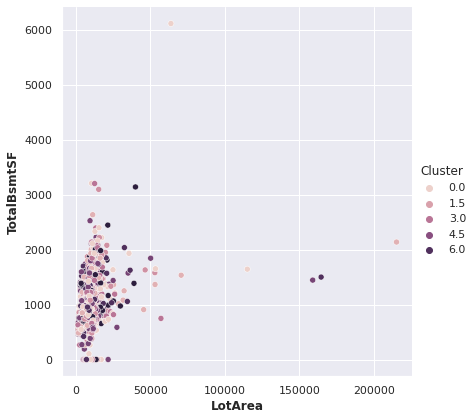

In [25]:

XclusterLabel= cluster_labels(X, cluster_features, n_clusters =8)
XclusterDistance= cluster_distance(X, cluster_features)

X["Cluster"] = XclusterLabel
#Xle["ClusterDistance"] = XclusterDistance

sns.relplot(
   x="LotArea" , y="TotalBsmtSF" , hue="Cluster", data=X, height=6,
);

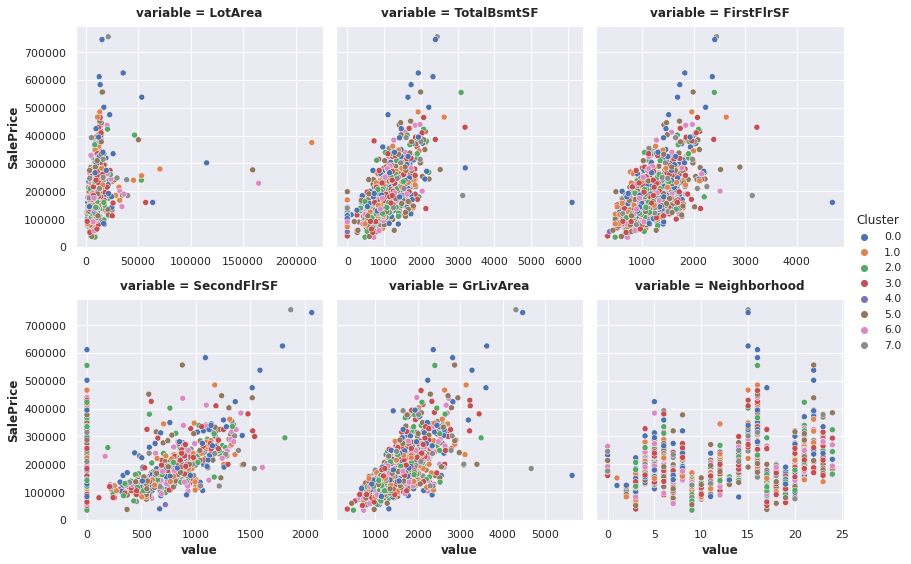

In [26]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=cluster_features, id_vars=["SalePrice", "Cluster"],
    ),
);

## Principal Component Analysis ##

PCA was the second unsupervised model we used for feature creation. We saw how it could be used to decompose the variational structure in the data. The PCA algorithm gave us *loadings* which described each component of variation, and also the *components* which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are the utility functions from the PCA lesson:

In [27]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


And here are transforms that produce the features from the Exercise 5. You might want to change these if you came up with a different answer.


In [28]:

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
    "Neighborhood",
    
]

These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:

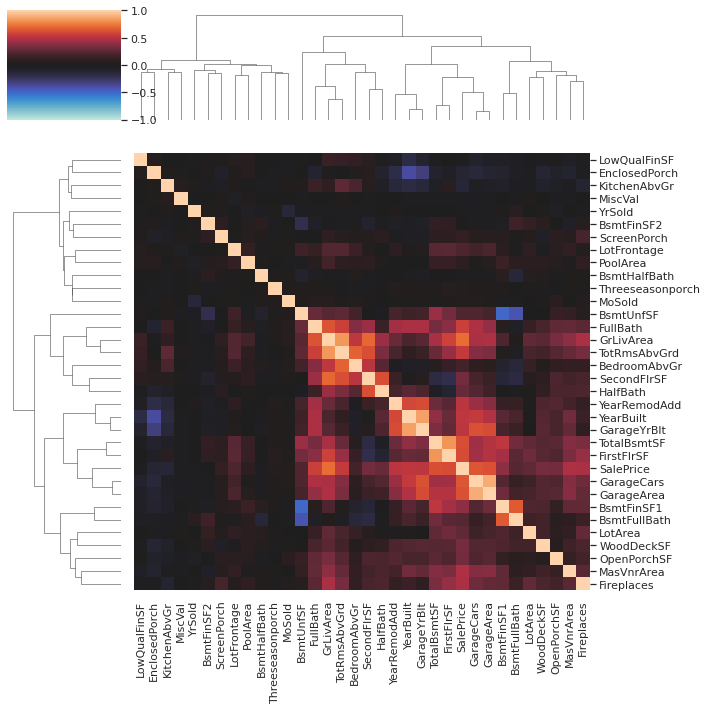

In [29]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None) # plot Xfinal

Groups of highly correlated features often yield interesting loadings.

### PCA Application - Indicate Outliers ###

In Exercise 5, you applied PCA to determine houses that were **outliers**, that is, houses having values not well represented in the rest of the data. You saw that there was a group of houses in the `Edwards` neighborhood having a `SaleCondition` of `Partial` whose values were especially extreme.

Some models can benefit from having these outliers indicated, which is what this next transform will do.

In [30]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new


You could also consider applying some sort of robust scaler from scikit-learn's `sklearn.preprocessing` module to the outlying values, especially those in `GrLivArea`. [Here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's [outlier detectors](https://scikit-learn.org/stable/modules/outlier_detection.html).

## Target Encoding ##

Needing a separate holdout set to create a target encoding is rather wasteful of data. In *Tutorial 6* we used 25% of our dataset just to encode a single feature, `Zipcode`. The data from the other features in that 25% we didn't get to use at all.

There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:
1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper you can use with any target encoder:

In [31]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


Use it like:

```
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
```

You can turn any of the encoders from the [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/) library into a cross-fold encoder. The [`CatBoostEncoder`](http://contrib.scikit-learn.org/category_encoders/catboost.html) would be worth trying. It's similar to `MEstimateEncoder` but uses some tricks to better prevent overfitting. Its smoothing parameter is called `a` instead of `m`.

## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [32]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # new Transformations
    X = X.join(diffGrLivArea(X))
    X = X.join(logTransformer(X))
    
    
    X = label_encode(X) 
        
    # Lesson 4 - Clustering
    X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    #X = X.join(cluster_distance(X, cluster_features, n_clusters=20)) #

    # Lesson 5 - PCA #
    #X = X.join(pca_inspired(X))
    #X = X.join(pca_components(X, pca_features))
    #X = X.join(indicate_outliers(X))

      

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))
        #X_test = X_test.fillna('bfill')  
        
    if df_test is not None:
        #X=X.fillna('bfill')  
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.14254681703465139

In [33]:
X_train.fillna(method='ffill', inplace= True)
X_test.fillna(method='ffill', inplace= True)


def check_missed_values(all_data):
    all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    return missing_data

check_missed_values(X_train)


,Missing Ratio


# Step 4 - Hyperparameter Tuning #

At this stage, you might like to do some hyperparameter tuning with XGBoost before creating your final submission.

In [34]:
#X_train = create_features(df_train)
#y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.1246171947138812

### Tuning to Hyperparameters

We used the library ´optuna´ for this process.

In [35]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
xgb_params = study.best_params

[I 2022-08-10 15:31:30,936] A new study created in memory with name: no-name-76cd162b-935c-4bcf-a500-3e73e686a5a5
[I 2022-08-10 15:33:43,539] Trial 0 finished with value: 0.12523070375863432 and parameters: {'max_depth': 4, 'learning_rate': 0.07990864418776197, 'n_estimators': 5938, 'min_child_weight': 6, 'colsample_bytree': 0.9600202674481157, 'subsample': 0.3677486466875953, 'reg_alpha': 0.05383029419053908, 'reg_lambda': 0.4397770744662958}. Best is trial 0 with value: 0.12523070375863432.
[I 2022-08-10 15:36:00,264] Trial 1 finished with value: 0.12092953433817388 and parameters: {'max_depth': 9, 'learning_rate': 0.005167459280580282, 'n_estimators': 4153, 'min_child_weight': 4, 'colsample_bytree': 0.5958816172010266, 'subsample': 0.792197275466372, 'reg_alpha': 0.3707195271922529, 'reg_lambda': 0.0001771101414623181}. Best is trial 1 with value: 0.12092953433817388.
[I 2022-08-10 15:37:24,611] Trial 2 finished with value: 0.11891471380978738 and parameters: {'max_depth': 4, 'learn

In [36]:
xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.11891471380978738

Just tuning these by hand can give you great results. However, you might like to try using one of scikit-learn's automatic [hyperparameter tuners](https://scikit-learn.org/stable/modules/grid_search.html). Or you could explore more advanced tuning libraries like [Optuna](https://optuna.readthedocs.io/en/stable/index.html) or [scikit-optimize](https://scikit-optimize.github.io/stable/).

Here is how you can use Optuna with XGBoost:

```
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params
```

Copy this into a code cell if you'd like to use it, but be aware that it will take quite a while to run. After it's done, you might enjoy using some of [Optuna's visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html).

# Step 5 - Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- create your feature set from the original data
- train XGBoost on the training data
- use the trained model to make predictions from the test set
- save the predictions to a CSV file


### Other Models

In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV, RidgeCV

y_train = df_train.loc[:, "SalePrice"]

gbr = GradientBoostingRegressor(loss='huber',random_state=42)  
gbr.fit(X_train, np.log(y_train))


ridge = RidgeCV()
ridge.fit(X_train, np.log(y_train))

SVM = SVR(C= 20, epsilon= 0.008, gamma=0.0003)
SVM.fit(X_train, np.log(y_train))

xgb.fit(X_train, np.log(y))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7430579538261304, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.010609654269962817,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=3520, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.05769007641090065, reg_lambda=0.00015188498661852207, ...)

In [38]:
from sklearn.metrics import mean_squared_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y) , np.log( y_pred )))

## Models

In [39]:
MHPred =  np.exp( 0.1*ridge.predict(X_train)+0.8*xgb.predict(X_train) + 0.1*SVM.predict(X_train) )##+ 0.1*randomFR.predict(X_train))
xgbPLUSridge = np.exp( 0.4*ridge.predict(X_train)+0.6*xgb.predict(X_train) )
XGBPred = np.exp(xgb.predict(X_train) )
RPred = np.exp(ridge.predict(X_train) )
SVMPred = np.exp(SVM.predict(X_train) )
                 
             

### RMSL for the models

In [40]:
print("Model Hybrid:", rmsle(y_train , MHPred),"\n",
      "xgb + ridge:", rmsle(y_train, xgbPLUSridge), "\n", 
      "XGB: ",  rmsle(y_train , XGBPred), "\n",
      "Ridge: ",  rmsle(y_train , RPred),"\n",
      "SVM: ",  rmsle(y_train , SVMPred),"\n",
     )


Model Hybrid: 0.029568233029551336 
 xgb + ridge: 0.059764015748899835 
 XGB:  0.025352322500730502 
 Ridge:  0.12315260261247299 
 SVM:  0.007976489327412857 



# Predicctions

In [41]:
predictions = np.exp(0.15*ridge.predict(X_test)+0.8*xgb.predict(X_test) + 0.05*SVM.predict(X_test) )
predxr = np.exp( 0.5*ridge.predict(X_test)+0.5*xgb.predict(X_test) )


In [42]:
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions })
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved-! \n")

print("Size: ", output.shape)

Your submission was successfully saved-! 

Size:  (1459, 2)


To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/221677) to chat with other Learners.*